# This notebook allows us to check results month by month and model by model

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
from matplotlib import pyplot
from placed_functions import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from lightgbm import plot_importance
from lightgbm import LGBMClassifier

import joblib
import time

Using TensorFlow backend.


## This function do the data prepartion, split and give us the good datasets according to the months we are checking

# We choose here which month we wan't to check

In [2]:
all_month = ['01', '02','03','05', '06','07', '08']

month = all_month[1]

print(f'The month is {month}')
display = True
save_model = True
A = prepare_and_split_data_placed(pd.read_hdf(f'../data/{month}_train_runners.h5','features'),
                                    pd.read_hdf(f'../data/{month}_test_runners.h5','features'))

if A !=False :
    X_train, y_train, X_test, y_test, y_train_value, y_test_value, X_test_init = A
    print(f"The mean place_odds for this month is {mean_place_odds(X_test_init)}")

The month is 02
shape of the x_train:  (5881, 1618)
shape of the y_train:  (5881, 14)
shape of the X_test:  (68, 1618)
shape of the y_test:  (68, 14)
The mean place_odds for this month is 7.650116009280742


# Deep learning

In [3]:
model = keras.models.load_model(f'model/placed_DL_{month}.h5')

y_pred = model.predict(X_test)

In [4]:
X_test_init.place_odds.head()

horse_no,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
5961,3.1,4.2,3.4,2.1,8.2,3.6,3.1,3.8,2.1,4.1,4.8,2.4,0.0,0.0
5962,1.3,3.3,3.1,2.7,33.0,6.4,1.9,15.0,3.3,8.6,1.8,5.7,0.0,0.0
5963,4.5,4.0,2.9,5.4,23.0,2.1,8.3,9.8,1.4,14.0,1.6,1.8,0.0,0.0
5964,2.8,3.3,12.0,1.3,7.1,2.3,1.5,0.0,4.3,3.3,3.8,6.9,0.0,0.0
5965,1.5,3.1,1.7,26.0,1.3,3.5,2.4,4.9,2.9,12.0,0.0,0.0,0.0,0.0


In [5]:
match_race_id_from_indices = X_test_init.race_id.to_list()
revenue,hm_bet,good_guesses,mean_sucess_pred =  compute_gain(y_test,y_pred,X_test_init,match_race_id_from_indices)


print(f'how many good guess we made {good_guesses} over {hm_bet} bets.') 
print(f"it's a percentage of {100*(good_guesses/hm_bet)} success") 
#print(f"Some hyperparameters num_neutron : {num_neutron}, batch_size: {batch_size}, epoch : {epoch}")
print(f"we win ${revenue} from our bet and the mean of the win_odds is {mean_sucess_pred}")
print(f"the mean win_odds for the favorite {function_less_place_odds(X_test_init)}")
print(f"we have a profit of {revenue-hm_bet} $")

how many good guess we made 65 over 204 bets.
it's a percentage of 31.862745098039213 success
we win $681.2000000000003 from our bet and the mean of the win_odds is 10.48
the mean win_odds for the favorite 1.6286764705882355
we have a profit of 477.2000000000003 $


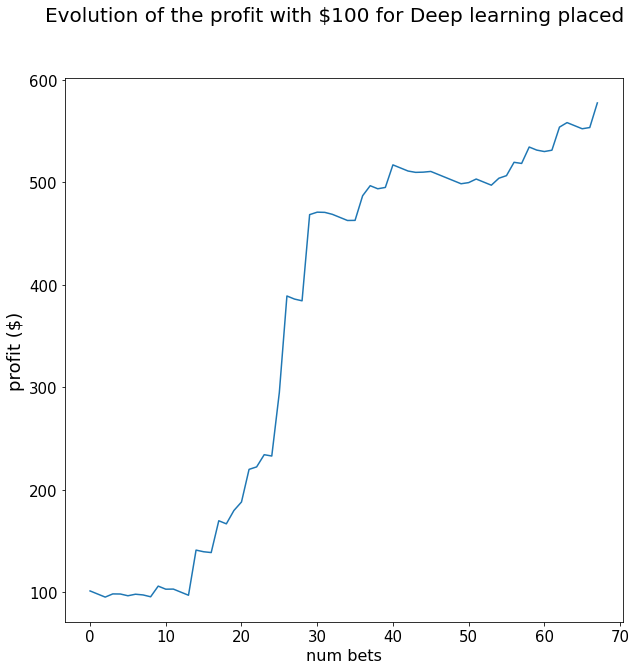

In [6]:
if display :
    draw_evolution_race(compute_df_placed(y_pred,y_test.values,X_test_init, match_race_id_from_indices),'Deep learning placed')

# LGBM with winner models

In [13]:
filename = f'model/winner_lgbm_{month}'

#load saved model
lgbm = joblib.load(filename)

In [14]:
y_pred_lgbm= lgbm.predict_proba(X_test)

In [15]:
match_race_id_from_indices = X_test_init.race_id.to_list()
revenue,hm_bet,good_guesses,mean_sucess_pred =  compute_gain(y_test,y_pred_lgbm,X_test_init,match_race_id_from_indices)


print(f'how many good guess we made {good_guesses} over {hm_bet} bets.') 
print(f"it's a percentage of {100*(good_guesses/hm_bet)} success") 
print(f"we win ${revenue} from our bet and the mean of the place_odds is {mean_sucess_pred}")
print(f"the mean win_odds for the favorite {function_less_place_odds(X_test_init)}")
print(f"we have a profit of {revenue-hm_bet}")

how many good guess we made 96 over 204 bets.
it's a percentage of 47.05882352941176 success
we win $650.4999999999999 from our bet and the mean of the place_odds is 6.776041666666667
the mean win_odds for the favorite 1.6286764705882355
we have a profit of 446.4999999999999


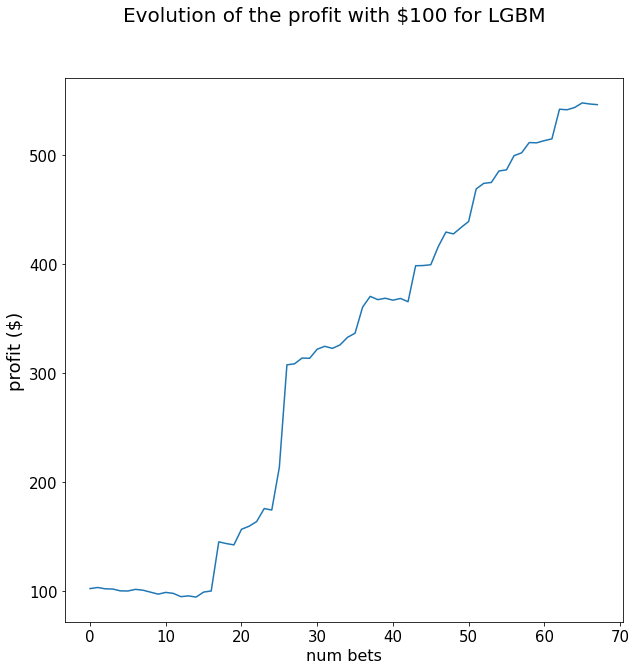

In [16]:
if display :
    draw_evolution_race(compute_df_placed(y_pred_lgbm,y_test.values,X_test_init, match_race_id_from_indices),'LGBM')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Feature importance for lgbm')

Text(0.5, 0, 'Feature importance')

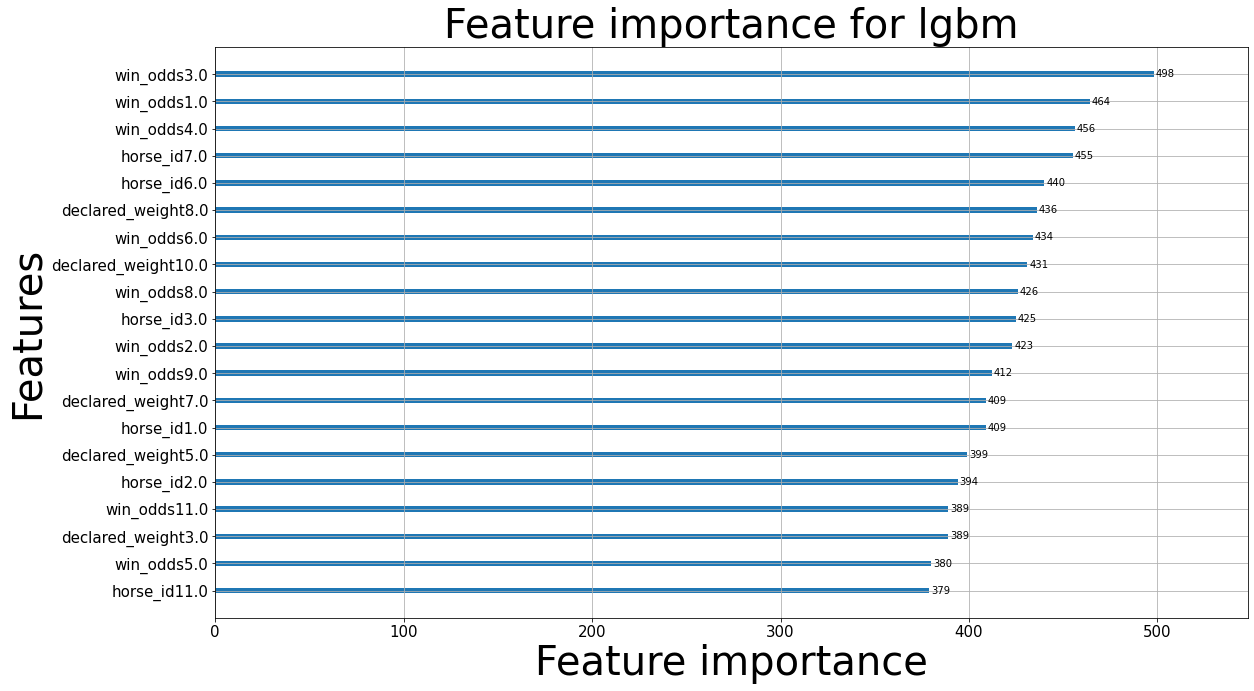

In [18]:
plot_importance(lgbm,max_num_features=20)
pyplot.gcf().set_size_inches(18.5, 10.5)
pyplot.ylabel('Features', fontsize=40)
pyplot.title('Feature importance for lgbm', fontsize=40)
pyplot.xlabel('Feature importance', fontsize=40)
pyplot.tick_params(axis='y', labelsize=15)
pyplot.tick_params(axis='x', labelsize=15)
pyplot.show()

# Ensemble model (both)

In [12]:
pred_proba_dl = model.predict_proba(X_test)
pred_proba_lgbm = lgbm.predict_proba(X_test)

pred_classes = ensemble_model_placed(pred_proba_dl,pred_proba_lgbm,0.3)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [13]:
match_race_id_from_indices = X_test_init.race_id.to_list()
revenue,hm_bet,good_guesses,mean_sucess_pred =  compute_gain(y_test,pred_classes,X_test_init,match_race_id_from_indices)


print(f'how many good guess we made {good_guesses} over {hm_bet} bets.') 
print(f"it's a percentage of {100*(good_guesses/hm_bet)} success") 
print(f"we win ${revenue} from our bet and the mean of the win_odds is {mean_sucess_pred}")
print(f"the mean win_odds for the favorite {function_less_place_odds(X_test_init)}")
print(f"we have a profit of {revenue-hm_bet}")

how many good guess we made 89 over 204 bets.
it's a percentage of 43.627450980392155 success
we win $630.6 from our bet and the mean of the win_odds is 7.085393258426967
the mean win_odds for the favorite nan
we have a profit of 426.6


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


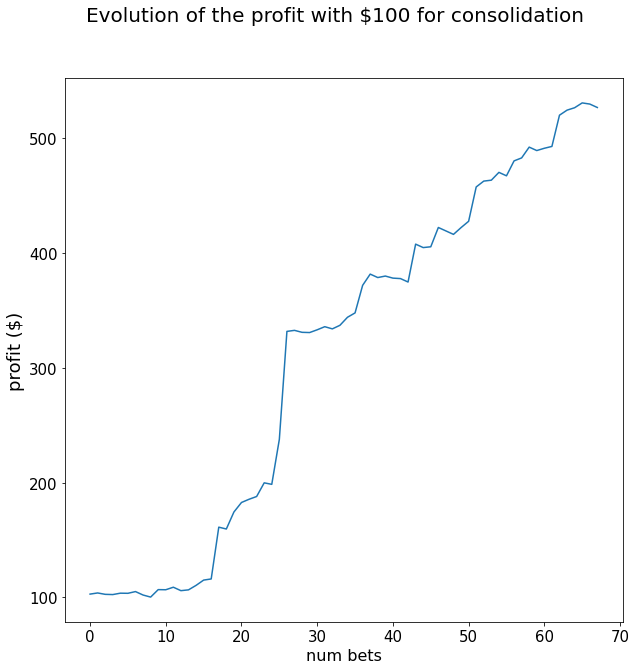

In [14]:
if display :
    draw_evolution_race(compute_df_placed(pred_classes,y_test.values,X_test_init, match_race_id_from_indices),'consolidation')